In [ ]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras

In [3]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9686 sha256=0a0b1de8356bbdb276ead68edf9ce7ad660b1740488c3aeb1e122c0da90bd10f
  Stored in directory: c:\users\yesys\appdata\local\pip\cache\wheels\a1\b6\7c\0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [10]:
import wget
if not os.path.exists("Stanford_politeness_corpus.zip"):
  wget.download("http://www.cs.cornell.edu/~cristian/Politeness_files/Stanford_politeness_corpus.zip") 

In [13]:
data = pd.read_csv(r'C:\Users\yesys\Downloads\nlp_study\임베딩\Stanford_politeness_corpus\Stanford_politeness_corpus\wikipedia.annotated.csv')
data.head()

,Community,Id,Request,Score1,Score2,Score3,Score4,Score5,TurkId1,TurkId2,TurkId3,TurkId4,TurkId5,Normalized Score
0,Wikipedia,629705,Where did you learn English? How come you're t...,13,9,11,11,5,A2UFD1I8ZO1V4G,A2YFPO0N4GIS25,AYG3MF094634L,A38WUWONC7EXTO,A15DM9BMKZZJQ6,-1.120049
1,Wikipedia,244336,Thanks very much for your edit to the <url> ar...,23,16,24,21,25,A2QN0EGBRGJU1M,A2GSW5RBAT5LQ5,AO5E3LWBYM72K,A2ULMYRKQMNNFG,A3TFQK7QK8X6LM,1.313955
2,Wikipedia,627353,Sir i think u hav many friends on wiki who can...,17,17,11,10,9,A233ONYNWKDIYF,A2UFD1I8ZO1V4G,A2MWGIVIKOXWYM,A1F4D2PZ7NNWTL,A1RT9SQ9D9DLOV,-0.247941
3,Wikipedia,448565,I can't find it. Maybe I didn't manage to gue...,17,9,16,16,9,A233ONYNWKDIYF,A1TLLJDX8H4JP1,AC25X12LNYY6Y,A1F4D2PZ7NNWTL,AEYHIQUDWJ3KV,0.058298
4,Wikipedia,625810,"I can't spend too much time, and I'm no specia...",17,14,17,11,17,A21753FQKCM5DQ,AYG3MF094634L,A3EJ5TT2ZGBIDA,A1F4D2PZ7NNWTL,A1RT9SQ9D9DLOV,0.346093


In [19]:
def load_data(data_file):
    data = pd.read_csv(data_file)
    
    quantiles = data["Normalized Score"].quantile([0.25, 0.5, 0.75])
    print(quantiles)
    
    for i in range(len(data)):
        score = data.loc[i, "Normalized Score"]
        if score <= quantiles[0.25]:
            # 하위 25% (impolite)
            data.loc[i, "Normalized Score"] = 0
        elif score >= quantiles[0.75]:
            data.loc[i, "Normalized Score"] = 1
        else:
            data.loc[i, "Normalized Score"] = 2
    data["Normalized Score"] = data["Normalized Score"].astype(int)
    # neutral example 버리기
    data = data[data["Normalized Score"] < 2]
    data = data.sample(frac=1).reset_index(drop=True)
    
    return data

In [21]:
data = load_data("./Stanford_politeness_corpus/Stanford_politeness_corpus/wikipedia.annotated.csv")
# 최대 열 개수 제한 해제
pd.set_option('display.max_columns', None)
data.head()

0.25   -0.442633
0.50    0.052339
0.75    0.514399
Name: Normalized Score, dtype: float64


,Community,Id,Request,Score1,Score2,Score3,Score4,Score5,TurkId1,TurkId2,TurkId3,TurkId4,TurkId5,Normalized Score
0,Wikipedia,625057,"Again, why are you simply reverting wholesale ...",5,9,14,8,4,AISPSIJ54U4SC,AE3D6SE2D8UPQ,AYG3MF094634L,A1E0EK09CA5OIO,AZOAW8JH5HJJK,0
1,Wikipedia,618997,"OK, we are talking about two remaining article...",9,4,3,9,17,A2UFD1I8ZO1V4G,A22SZHZTF72TRM,A6YO9886DY2SC,AYG3MF094634L,A1BJTTNDDFZ3ZP,0
2,Wikipedia,550745,'''I just take care of the problem.''' Can't y...,6,5,9,9,13,A1T5YMBH35PDBX,A233ONYNWKDIYF,A3S5L3I8O3Q2G,A1G05O3HM7DNVZ,AIPK94CUWL45W,0
3,Wikipedia,318563,"<url> is, in reality, a good guy, and quite re...",13,22,25,20,17,A233ONYNWKDIYF,A2WKPCZU4U110T,A6YO9886DY2SC,AO5E3LWBYM72K,A1DTQSIIYIZL62,1
4,Wikipedia,389087,"Don't push it, Zachary. Can you give me proof ...",13,9,9,9,4,A233ONYNWKDIYF,A2UFD1I8ZO1V4G,A22SZHZTF72TRM,A1DTQSIIYIZL62,A38N58BSMTA0BE,0


사전 구성하기  
신경망 입력으로 사용하기 위해선 문장을 숫자로 바꿔야 하는데, 사전을 통해 단어를 숫자로, 숫자를 단어로 바꿔준다  
dictionary 자료 구조를 사용하는 것이 일반적이다  
1. 문장들을 소문자로 바꾸고, tokenization
2. 전체 데이터에서 각 토큰들의 등장 빈도 확인
3. 가장 등장 빈도 높은 단어를 vocab_size만큼 선택(Counter의 most_common 함수 활용)
4. 각각의 단어에 고유한 숫자 부여. 이때, 0번째 토큰은 ""
5. 토큰 -> 숫자 변환을 위한 dictionary(word_Index 변수에 할당)와,  숫자 -> 토큰 변환을 위한 dictionary (word_inverted_index 변수에 할당)생성


In [32]:
word_counter = Counter()
sentences = data["Request"].tolist()
for sent in sentences:
    tokens = word_tokenize(sent.lower())
    word_counter.update(tokens)
print(len(word_counter))
print(word_counter)

6490
Counter({'?': 2714, 'the': 2502, 'you': 2239, ',': 2204, 'to': 1698, 'i': 1683, '.': 1636, 'a': 1127, 'it': 964, 'that': 936, 'of': 858, '>': 836, '<': 835, 'is': 814, 'and': 794, 'url': 759, 'do': 678, 'for': 630, 'in': 596, 'on': 593, "''": 525, 'have': 487, '``': 475, "n't": 464, 'what': 463, 'be': 451, 'this': 444, 'are': 406, 'your': 395, 'not': 384, "'s": 373, 'was': 343, 'with': 342, 'article': 335, 'if': 328, 'would': 322, 'me': 301, 'can': 300, 'why': 294, 'as': 294, 'but': 293, 'page': 290, 'or': 280, 'at': 256, ')': 251, 'could': 251, 'there': 233, 'did': 230, 'about': 226, 'so': 223, 'my': 221, 'how': 212, '(': 210, 'an': 206, 'any': 201, 'just': 194, 'think': 193, ':': 179, 'should': 177, 'like': 172, "'m": 171, 'from': 171, 'thanks': 170, 'we': 163, '-': 156, 'by': 150, 'see': 142, 'know': 141, 'one': 140, 'please': 137, "'ve": 136, 'does': 133, 'hi': 132, '!': 131, 'which': 128, 'been': 127, 'all': 121, 'no': 120, 'talk': 119, 'more': 117, 'has': 114, 'some': 113, '

In [31]:
most_common = word_counter.most_common()
most_common[:10]

[('?', 2714),
 ('the', 2502),
 ('you', 2239),
 (',', 2204),
 ('to', 1698),
 ('i', 1683),
 ('.', 1636),
 ('a', 1127),
 ('it', 964),
 ('that', 936)]

In [25]:
vocab_size = 5000
# we assign the first indices in the vocabulary to special tokens that we use
# for padding, and for indicating unknown words
pad_id = 0
oov_id = 1
index_offset = 1

def make_vocab(sentences):
  word_counter = Counter()

  for sent in sentences:
    tokens = word_tokenize(sent.lower())
    word_counter.update(tokens)
  
  most_common = word_counter.most_common()
  print("고빈도 단어:")
  for k, v in most_common[:10]:
    print(k, ": ", v)
  
  vocab = {
      '<PAD>': pad_id,
      '<OOV>': oov_id
  }
  for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
    vocab[word] = i
    if len(vocab) >= vocab_size:
      break
  
  return vocab
  
sentences = data["Request"].tolist()
word_index = make_vocab(sentences)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
  print(i, word_inverted_index[i])
  
print("\n단어 사전 크기: ", len(word_index))

고빈도 단어:
? :  2714
the :  2502
you :  2239
, :  2204
to :  1698
i :  1683
. :  1636
a :  1127
it :  964
that :  936

단어 사전:
0 <PAD>
1 <OOV>
2 ?
3 the
4 you
5 ,
6 to
7 i
8 .
9 a

단어 사전 크기:  5000


In [26]:
word_index

{'<PAD>': 0,
 '<OOV>': 1,
 '?': 2,
 'the': 3,
 'you': 4,
 ',': 5,
 'to': 6,
 'i': 7,
 '.': 8,
 'a': 9,
 'it': 10,
 'that': 11,
 'of': 12,
 '>': 13,
 '<': 14,
 'is': 15,
 'and': 16,
 'url': 17,
 'do': 18,
 'for': 19,
 'in': 20,
 'on': 21,
 "''": 22,
 'have': 23,
 '``': 24,
 "n't": 25,
 'what': 26,
 'be': 27,
 'this': 28,
 'are': 29,
 'your': 30,
 'not': 31,
 "'s": 32,
 'was': 33,
 'with': 34,
 'article': 35,
 'if': 36,
 'would': 37,
 'me': 38,
 'can': 39,
 'why': 40,
 'as': 41,
 'but': 42,
 'page': 43,
 'or': 44,
 'at': 45,
 ')': 46,
 'could': 47,
 'there': 48,
 'did': 49,
 'about': 50,
 'so': 51,
 'my': 52,
 'how': 53,
 '(': 54,
 'an': 55,
 'any': 56,
 'just': 57,
 'think': 58,
 ':': 59,
 'should': 60,
 'like': 61,
 "'m": 62,
 'from': 63,
 'thanks': 64,
 'we': 65,
 '-': 66,
 'by': 67,
 'see': 68,
 'know': 69,
 'one': 70,
 'please': 71,
 "'ve": 72,
 'does': 73,
 'hi': 74,
 '!': 75,
 'which': 76,
 'been': 77,
 'all': 78,
 'no': 79,
 'talk': 80,
 'more': 81,
 'has': 82,
 'some': 83,
 'hel

In [27]:
word_inverted_index

{0: '<PAD>',
 1: '<OOV>',
 2: '?',
 3: 'the',
 4: 'you',
 5: ',',
 6: 'to',
 7: 'i',
 8: '.',
 9: 'a',
 10: 'it',
 11: 'that',
 12: 'of',
 13: '>',
 14: '<',
 15: 'is',
 16: 'and',
 17: 'url',
 18: 'do',
 19: 'for',
 20: 'in',
 21: 'on',
 22: "''",
 23: 'have',
 24: '``',
 25: "n't",
 26: 'what',
 27: 'be',
 28: 'this',
 29: 'are',
 30: 'your',
 31: 'not',
 32: "'s",
 33: 'was',
 34: 'with',
 35: 'article',
 36: 'if',
 37: 'would',
 38: 'me',
 39: 'can',
 40: 'why',
 41: 'as',
 42: 'but',
 43: 'page',
 44: 'or',
 45: 'at',
 46: ')',
 47: 'could',
 48: 'there',
 49: 'did',
 50: 'about',
 51: 'so',
 52: 'my',
 53: 'how',
 54: '(',
 55: 'an',
 56: 'any',
 57: 'just',
 58: 'think',
 59: ':',
 60: 'should',
 61: 'like',
 62: "'m",
 63: 'from',
 64: 'thanks',
 65: 'we',
 66: '-',
 67: 'by',
 68: 'see',
 69: 'know',
 70: 'one',
 71: 'please',
 72: "'ve",
 73: 'does',
 74: 'hi',
 75: '!',
 76: 'which',
 77: 'been',
 78: 'all',
 79: 'no',
 80: 'talk',
 81: 'more',
 82: 'has',
 83: 'some',
 84: 

사전이 잘 구성되었는지 확인하기  
문장 -> 숫자 -> 문장으로 돌아오는 것 확인하기

In [33]:
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

def text_to_index(text):
    tokens = word_tokenize(text.lower())
    indexes = []
    for tok in tokens:
        if tok in word_index:
            indexes.append(word_index[tok])
        else:
            indexes.append(oov_id)
    
    return indexes

print("원본 : ", sentences[0])
ids = text_to_index(sentences[0])
print("문자 -> 숫자 : ", ids)
print("숫자 -> 문자 : ", index_to_text(ids))

원본 :  Again, why are you simply reverting wholesale and without any explanation? Would you rather the article be out of line with the policies and guidelines, among other problems?
문자 -> 숫자 :  [124, 5, 40, 29, 4, 372, 387, 1319, 16, 222, 56, 407, 2, 37, 4, 227, 3, 35, 27, 108, 12, 408, 34, 3, 808, 16, 921, 5, 809, 93, 319, 2]
숫자 -> 문자 :  again , why are you simply reverting wholesale and without any explanation ? would you rather the article be out of line with the policies and guidelines , among other problems ?


숫자로 바뀐 문장들 학습 데이터로 사용할 수 있도록 변형하기  
1. 모든 문장들을 동일한 길이가 되도록 padding 처리하거나 자름
2. 데이터의 일부(10%)를 테스트 데이터로 분리

In [34]:
x_variable = [text_to_index(sent) for sent in sentences]

sentence_size = 200
#truncating : sentence_size 초과 시 앞에서 자를 지, 뒤에서 자를 지
# padding : sentence_size보다 작을 시 앞을 채울 지, 뒤를 채울 지
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

n_test = len(data) // 10
test_inputs = x_padded[:n_test]
train_inputs = x_padded[n_test:]

ys = np.array(data["Normalized Score"].tolist())
test_labels = ys[:n_test]
train_labels = ys[n_test:]


print("test_inputs shape: ", test_inputs.shape)
print("train_inputs shape: ", train_inputs.shape)
print("test_labels shape: ", test_labels.shape)
print("train_labels shape: ", train_labels.shape)

test_inputs shape:  (217, 200)
train_inputs shape:  (1961, 200)
test_labels shape:  (217,)
train_labels shape:  (1961,)


In [35]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 50),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [37]:
def plot_loss(history):
  plt.figure(figsize=(6,5))
  val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
  plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  
def eval_model(model):
  test_loss, test_acc = model.evaluate(test_inputs, test_labels)
  print('Test accuracy:', test_acc)

Train on 1961 samples, validate on 217 samples
Epoch 1/10
1961/1961 [==============================] - 3s 1ms/sample - loss: 0.6755 - accuracy: 0.6135 - val_loss: 0.6379 - val_accuracy: 0.6406
Epoch 2/10
1961/1961 [==============================] - 1s 565us/sample - loss: 0.5633 - accuracy: 0.8103 - val_loss: 0.5009 - val_accuracy: 0.8157
Epoch 3/10
1961/1961 [==============================] - 1s 546us/sample - loss: 0.4093 - accuracy: 0.8695 - val_loss: 0.4063 - val_accuracy: 0.8571
Epoch 4/10
1961/1961 [==============================] - 1s 523us/sample - loss: 0.2973 - accuracy: 0.9052 - val_loss: 0.3714 - val_accuracy: 0.8433
Epoch 5/10
1961/1961 [==============================] - 1s 503us/sample - loss: 0.2106 - accuracy: 0.9398 - val_loss: 0.3550 - val_accuracy: 0.8571
Epoch 6/10
1961/1961 [==============================] - 1s 534us/sample - loss: 0.1434 - accuracy: 0.9658 - val_loss: 0.3513 - val_accuracy: 0.8664
Epoch 7/10
1961/1961 [==============================] - 1s 524us/sa

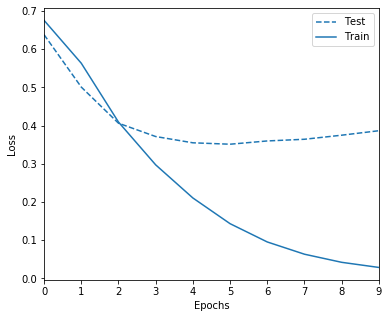

In [38]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_inputs,
          train_labels,
          epochs=10,
          validation_data=(test_inputs, test_labels)
         )

plot_loss(history)
eval_model(model)

Pretrained word vectors 이용하기  
GloVe 벡터 사용

In [40]:
if not os.path.exists('glove.6B.zip'):
    wget.download("http://nlp.stanford.edu/data/glove.6B.zip")

100% [......................................................................] 862182613 / 862182613

In [41]:
import zipfile
if not os.path.exists('glove.6B.50d.txt'):
    glove_zip = zipfile.ZipFile('./glove.6B.zip')
    glove_zip.extractall('./')
    glove_zip.close()

GloVe 벡터 불러와 임베딩 행렬 초기화  
1. Glove 파일에서, 각 줄에서 단어(1번째 토큰)와 벡터를 이루는 숫자들(2번쨰 이후 토큰들) 분리
2. 벡터를 이루는 숫자들을 numpy행렬로 변환(numpy의 asarray 함수 활용)
3. 단어와 벡터 연결하는 dictionary 자료구조 구성( 단어 -> 벡터)
4. 모든 단어들에 대한 임베딩 행렬 무작위 생성
5. 임베딩 행렬에서 GloVe 벡터가 존재하는 단어들만 해당 GloVe 벡터로 대체

In [43]:
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding = 'utf-8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype = 'float32')
            embeddings[w] = vectors
    embedding_matrix = np.random.uniform(-1, 1, size = (vocab_size, 50))
    num_loaded = 0
    # w:word, i:index, v:vector
    for w, i in word_index.items():
        v = embeddings.get(w)
        if v is not None and i < vocab_size:
            embedding_matrix[i] = v
            num_loaded += 1
    print('Successfully loaded pretrained embeddings for'f'{num_loaded}/{vocab_size} words.')
    embedding_matrix = embedding_matrix.astype(np.float32)
    return embedding_matrix

embedding_matrix = load_glove_embeddings('glove.6B.50d.txt')

Successfully loaded pretrained embeddings for4452/5000 words.


In [44]:
embedding_matrix[:10]

array([[-1.13376647e-01, -5.13859130e-02, -6.33177578e-01,
         3.16463172e-01,  2.96621591e-01,  9.54351962e-01,
        -5.47706366e-01, -2.36634225e-01,  5.31108916e-01,
        -9.13872063e-01,  7.84279644e-01,  8.14015329e-01,
         8.87150228e-01,  8.92023742e-01,  8.97703588e-01,
        -6.78998888e-01,  5.98679960e-01,  3.51970702e-01,
         9.34100628e-01,  7.33725786e-01,  2.92282075e-01,
        -4.66632724e-01, -6.91730440e-01, -9.38683808e-01,
        -1.36212558e-01,  1.68073457e-02, -4.88428473e-01,
         5.39241493e-01, -6.45979881e-01, -5.95110476e-01,
         2.23439425e-01, -5.14021456e-01, -8.37685168e-01,
        -1.83573216e-01,  1.76933542e-01,  9.44906890e-01,
         5.77814877e-01, -7.23444939e-01, -9.54303861e-01,
         6.64119124e-01, -2.61604637e-01, -7.84715787e-02,
         6.72678530e-01, -6.12848639e-01, -3.30806017e-01,
        -8.53903472e-01, -8.86664629e-01, -4.17028880e-03,
         7.63575912e-01,  5.17761767e-01],
       [-1.41

In [45]:
glove_init = keras.initializers.Constant(embedding_matrix)

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 50, embeddings_initializer=glove_init),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

Train on 1961 samples, validate on 217 samples
Epoch 1/10
1961/1961 [==============================] - 2s 1ms/sample - loss: 0.6977 - accuracy: 0.5548 - val_loss: 0.6696 - val_accuracy: 0.5576
Epoch 2/10
1961/1961 [==============================] - 1s 510us/sample - loss: 0.5851 - accuracy: 0.7047 - val_loss: 0.6196 - val_accuracy: 0.6682
Epoch 3/10
1961/1961 [==============================] - 1s 509us/sample - loss: 0.5016 - accuracy: 0.7935 - val_loss: 0.5625 - val_accuracy: 0.7373
Epoch 4/10
1961/1961 [==============================] - 1s 528us/sample - loss: 0.4173 - accuracy: 0.8608 - val_loss: 0.5097 - val_accuracy: 0.7834
Epoch 5/10
1961/1961 [==============================] - 1s 488us/sample - loss: 0.3503 - accuracy: 0.8909 - val_loss: 0.4676 - val_accuracy: 0.8065
Epoch 6/10
1961/1961 [==============================] - 1s 489us/sample - loss: 0.2843 - accuracy: 0.9347 - val_loss: 0.4357 - val_accuracy: 0.8203
Epoch 7/10
1961/1961 [==============================] - 1s 512us/sa

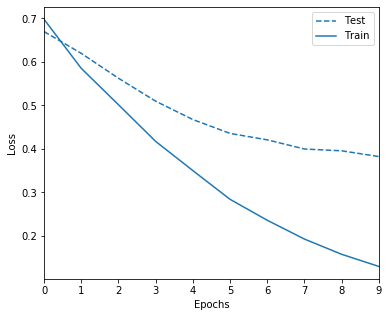

In [46]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_inputs,
          train_labels,
          epochs=10,
          validation_data=(test_inputs, test_labels)
         )

plot_loss(history)
eval_model(model)

추가 공부거리 : 왜 정확도가 더 낮아졌을까?  
추측 1: 임베딩 벡터에 존재하지 않는 단어의 임베딩을 무작위로 돌렸기 때문일 것